# Analysis of network of painters based on their locations throughout time

<u> **Description:**</u> The work contained in this notebook is part of a bigger project, only containing the construction of a painter network based on locations of painters throughout years, and analyzing, visualizing this network. The project includes gathering and cleaning data of painters, possibly the hardest task (and unfinished, e.g. same-painter with different alias instances still need to be combined) which I store in the GitHub repository [PainterPalette](https://github.com/me9hanics/PainterPalette), and some other analysis of styles, movements, static and dynamic networks of painters, stored under GitHub [ArtProject](https://github.com/me9hanics/ArtProject). We will only build on the first one, we use the painters stored in the `artists.csv` file.<br>
We have information on ~10000 painters from the 11th century (even before, but with nearly no info) to the 21st, their locations, time data, gender, nationality, how many artworks they painted per style, what movement they belonged to, a list of some of the painters who influenced them and who they influenced, the school they studied at and friends and coworkers. 

In this particular work, I wanted to gain insights about what common properties do painters have, that were connected by living at the same places at the same time (roughly, temporal data is sparse so I had to make compromises). Are these communities fairly even in percentage of females, or vary a lot? From very simple analysis before, we found that centuries ago the surroundings of a painter pretty much determined his/her artistic style too (social contagion). As transportation infrastructure developed (assumably that is the reason), the various styles started spreading more, and while location (in time) used to be a good indicator of an artistic style, it does not have as much of an impact anymore. <br>
I aim to find similar findings, by analyzing the communities directly in such a network. The final community structure, with some explanation will be a visualized nested blockmodel, from which we can also gain further insights, such as whether intra-community connections are stronger than inter-community ones (hinting at assortivity).

## Imports, initial procedures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#For the analysis, we will also need the analysis functions, stored in a separate file:
import analysis_functions

#Miscellaneous
import itertools

#Get the dataset of artists:
artists = pd.read_csv("data/artists.csv").drop(columns=["Type", "Contemporary"])#Type and contemporary are "artificial" columns, rather not look at it
#I typically load the data from the URL: https://raw.githubusercontent.com/me9hanics/PainterPalette/main/datasets/artists.csv
#   as I keep updating the file, allowing for fresh data to be used

In [2]:
from graph_tool.all import *

Let's see some of the data we have:

In [5]:
artists[10:15]

,artist,Nationality,citizenship,gender,styles,movement,Art500k_Movements,birth_place,death_place,birth_year,...,occupations,PaintingsExhibitedAt,PaintingsExhibitedAtCount,PaintingSchool,Influencedby,Influencedon,Pupils,Teachers,FriendsandCoworkers,ArtMovement
10,Friedrich Schroder-Sonnenstern,German,Germany,male,Art Brut,Outsider art (Art brut),{Outsider art (Art brut):10},Sovetsk,Berlin,1892.0,...,"painter, drawer",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,D. Jeffrey Mims,American,United States of America,male,Contemporary Realism,Classical Realism,{Classical Realism:10},North Carolina,NaN,1954.0,...,"painter, politician",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nuno Gonçalves,Portuguese,Kingdom of Portugal,male,Early Renaissance,Early Renaissance,{Early Renaissance:10},NaN,NaN,1425.0,...,"portraitist, painter, musician, researcher","Lisbon, Portugal","{Lisbon:1},{Portugal:1}",NaN,"National Museum of Ancient Art (MNAA), Lisbon,...",NaN,NaN,NaN,NaN,NaN
13,Alexander Khvostenko-Khvostov,"Russian,Ukrainian",Russian Empire,male,"Art Nouveau (Modern), Constructivism, Expressi...",Avant-garde,"{Avant-garde,Constructivism:21}","Borisovka, Borisovsky District, Belgorod Oblast",Kyiv,1885.0,...,"visual artist, scenographer, graphic artist, p...",NaN,NaN,ARMU (Association of Revolutionary Masters of ...,NaN,NaN,NaN,"Aleksandra Ekster,","Victor Palmov,David Burliuk,Oleksandr Bogomazo...",NaN
14,Jose Ferraz de Almeida Junior,Brazilian,Brazil,male,"Academicism, Realism",Realism,{Realism:64},Itu,Piracicaba,1850.0,...,painter,"Brazil, Rio de Janeiro, Sao Paulo","{Sao Paulo:30},{Brazil:36},{Rio de Janeiro:4}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
artists.columns

Index(['artist', 'Nationality', 'citizenship', 'gender', 'styles', 'movement',
       'Art500k_Movements', 'birth_place', 'death_place', 'birth_year',
       'death_year', 'FirstYear', 'LastYear', 'wikiart_pictures_count',
       'locations', 'locations_with_years', 'styles_extended', 'StylesCount',
       'StylesYears', 'occupations', 'PaintingsExhibitedAt',
       'PaintingsExhibitedAtCount', 'PaintingSchool', 'Influencedby',
       'Influencedon', 'Pupils', 'Teachers', 'FriendsandCoworkers',
       'ArtMovement'],
      dtype='object')

We see that years in birth/first/last year are floats instead of ints, this is because of `NaN` values and sadly cannot be changed. I tried to name columns in a way that they are self-explanatory, but it needs to be said that the difference between `movement` and `Art500k_Movements` is the first is from WikiArt data, the latter is Art500k, and `First/LastYear` means the earliest dated painting's year in the Art500k dataset.<br>
In general, capital letter attributes account for data gathered from Art500k, while lowercase ones are from WikiArt/Wikidata.

(In the future I hope to create a *JSON* format of the dataset, including paintings, hence why some attributes are stored in an unnatural way, e.g. the `Art500k_Movements` attribute has dicts stored in strings.)

For this analysis, we need only the locations of painters

## Creating the network:

### Locations in time painter network:

To connect painters based on their locations, I created a simple "index" (measure of similarity) for each pair of painters, that can be calculated the following way:


$$ index = \frac{{\text{{common years (in their lifetime)}}}}{{\text{{amount of places}}}} \times \text{{amount of common places}} $$


In reality, I computed the average common years per place for two artists, and took their average.
I connect any two painters that have this value above 0, then we filter later on over a threshold.<br>


Calculation: <br>
- For every common place shared, I added + 1 to common places (and because of small amount of places for many artists, I also added 0.3 bonus point for common nationality/citizenship)
- For every common year shared, I added + 1 to common years. However, I only looked at common active years (from first working year to last, usually from age 20 to death)

### Adding nodes and all possible edges:

In [3]:
import ast #string to list/dict functionality is included in it

We fill up missing time data for artists that have enough time data, just not all. This is done with `years_fixer(years)`, basically calibrates last/death year and first/birth year values if one is missing.

Precomputing (lookup speed could be faster than computing in each step, because dicts are faster than (Pandas) dataframes etc.):

In [4]:
#Geographical / time data
#['birth_place', 'death_place', 'Nationality','locations','locations_with_years' , 'birth_year','death_year' , 'FirstYear','LastYear','citizenship']

#Artist data instances (pandas series)
artist_data = {artist: artists[artists['artist']==artist].iloc[0] for artist in artists['artist']}

#Birthyear, first active year (Art500k), last active year, death year
years = {artist: analysis_functions.years_fixer([data['birth_year'], data['FirstYear'], data['LastYear'], data['death_year']]) for artist, data in artist_data.items()}

nationalities = {artist: np.nan if type(data['Nationality']) != str
                 else data['Nationality'].split(",") for artist, data in artist_data.items()}
places = {artist: [] if pd.isnull(data['locations'])
          else ast.literal_eval(data['locations']) for artist, data in artist_data.items()}#Literal eval to convert string to list

Now adding the nodes and all possible edges:

In [5]:
g = Graph(directed=False)

#Edgeweight property
weight = g.new_edge_property("double")

#Artist-vertex dictionary + property
vertex_dict = {}
artist_name = g.new_vertex_property("string")

for artist in artists['artist']:
    v = g.add_vertex()
    vertex_dict[artist] = v
    artist_name[v] = artist

for artist1, artist2 in itertools.combinations(artists['artist'], 2):
    artist1_data = artist_data[artist1]
    artist2_data = artist_data[artist2]
    
    years1 = years[artist1]
    years2 = years[artist2]
    if type(years1) != list or type(years2) != list: #np.nan
        continue

    birthplace1 = artist1_data["birth_place"]
    birthplace2 = artist2_data["birth_place"]
    
    nationalities1 = nationalities[artist1]
    nationalities2 = nationalities[artist2]
    
    citizenship1 = artist1_data['citizenship']
    citizenship2 = artist2_data['citizenship']
    
    places1_list = places[artist1]
    places2_list = places[artist2]
    
    index_val = analysis_functions.index_simple(places1_list, places2_list, years1, years2, birthplace1, birthplace2, 
                                                nationalities1, nationalities2, citizenship1, citizenship2, active_years_only=True)
    
    if (index_val > 0):
        e = g.add_edge(vertex_dict[artist1], vertex_dict[artist2])
        weight[e] = index_val

#Save property map
g.edge_properties["weight"] = weight
g.vertex_properties["artist_name"] = artist_name

In [8]:
#Save g as a graphml file
g.save("painters.graphml")

Some stats:

In [9]:
#Print number of nodes and edges
print("Number of nodes: ", g.num_vertices())
print("Number of edges: ", g.num_edges())
print("Smallest edge weight: ", min(weight.a))
print("Largest edge weight: ", max(weight.a))

Number of nodes:  10534
Number of edges:  415527
Smallest edge weight:  0.0031249999999999997
Largest edge weight:  174.79999999999998


Every artist has around 80 connections (of course this would be small, but considering for an artist how many of his/her connections are really in the dataset, this average may actually be high).

In [6]:
vertex_to_name = {value:key for key, value in vertex_dict.items()}.copy()

In [11]:
# Print top 25 edge weights
sorted_edges = sorted(g.edges(), key=lambda e: weight[e], reverse=True)
for edge in sorted_edges[:25]:
    print(vertex_to_name[edge.source()], "and", vertex_to_name[edge.target()], ": index =", weight[edge])

Sarah Purser and Robert Hunter : index = 174.79999999999998
Arthur Hughes and William Shakespeare Burton : index = 147.2
Louis Carrogis and Antoine de Marcenay de Ghuy : index = 144.89999999999998
Felix Nadar and Nadar : index = 133.39999999999998
Jean Baptiste Claude Odiot and Adèle Romany : index = 133.39999999999998
Marcus Stone and William Shakespeare Burton : index = 131.1
Antoine-François Callet and Felix Lecomte : index = 131.1
Richard Avedon and Paul Cadmus : index = 131.1
Jean Victor Bertin and Jean Baptiste Claude Odiot : index = 128.79999999999998
Samuel De Wilde and James Heath : index = 128.79999999999998
Isaac Walraven and Paulus Bramer : index = 128.79999999999998
Corneille and Joseph Charles Marin : index = 127.925
Anne Vallayer-Coster and Antoine-François Callet : index = 126.49999999999999
Johan Braakensiek and Petrus Johannes Arendzen : index = 126.49999999999999
Charles Thévenin and Jean Baptiste Claude Odiot : index = 126.49999999999999
James Heath and John Penn : 

The highest value edge is caused by Robert Hunter having wrong data (two Robert Hunters were collected in one) and thus Robert Hunter in the dataset has a "year span" of ~280 years.<br>
Felix Nadar and Nadar are the same person, hence why they have a high value too.

In [12]:
name1 = "Sarah Purser"; name2 = "Robert Hunter"
cols = ['artist','Nationality', 'citizenship', 'birth_place', 'birth_year', 'FirstYear', 'LastYear', 'death_year',  'locations']
artists[(artists['artist'] == name1) | (artists['artist'] == name2)][cols]

,artist,Nationality,citizenship,birth_place,birth_year,FirstYear,LastYear,death_year,locations
1769,Sarah Purser,NaN,Republic of Ireland,Dublin,1848.0,NaN,NaN,1943.0,['Dublin']
7417,Robert Hunter,Australian,Republic of Ireland,Dublin,1715.0,1991.0,1991.0,1803.0,['Dublin']


Others so far seem to be non-counterfeit.

In [13]:
name1 = "Jean Baptiste Claude Odiot"; name2 = "Charles Thévenin"
artists[(artists['artist'] == name1) | (artists['artist'] == name2)][cols]

,artist,Nationality,citizenship,birth_place,birth_year,FirstYear,LastYear,death_year,locations
5711,Charles Thévenin,NaN,France,Paris,1764.0,NaN,NaN,1838.0,['Paris']
8205,Jean Baptiste Claude Odiot,NaN,France,Paris,1763.0,NaN,NaN,1850.0,['Paris']


In [14]:
name1 = "Arthur Hughes"; name2 = "William Shakespeare Burton"
artists[(artists['artist'] == name1) | (artists['artist'] == name2)][cols]

,artist,Nationality,citizenship,birth_place,birth_year,FirstYear,LastYear,death_year,locations
2414,Arthur Hughes,British,United Kingdom of Great Britain and Ireland,London,1832.0,1845.0,1908.0,1915.0,['London']
4397,William Shakespeare Burton,NaN,United Kingdom of Great Britain and Ireland,London,1824.0,NaN,NaN,1916.0,['London']


Let's remove Robert Hunter and Nadar:

In [7]:
v1 = vertex_dict["Robert Hunter"]; v2 = vertex_dict["Nadar"]
g.remove_vertex(v1); g.remove_vertex(v2)
#However, now the vertex_dict is not correct, as vertices have been removed. We need to reset it:
vertex_dict = {} #Could have just removed the two removed vertices, and shifted everything after them
for v in g.vertices():
    artist_name = g.vp.artist_name[v]
    vertex_dict[artist_name] = v

vertex_to_name = {value:key for key, value in vertex_dict.items()}.copy()


In [8]:
# Print top 25 edge weights
sorted_edges = sorted(g.edges(), key=lambda e: weight[e], reverse=True)
for edge in sorted_edges[:25]:
    print(vertex_to_name[edge.source()], "and", vertex_to_name[edge.target()], ": index =", weight[edge])

Arthur Hughes and William Shakespeare Burton : index = 147.2
Louis Carrogis and Antoine de Marcenay de Ghuy : index = 144.89999999999998
Jean Baptiste Claude Odiot and Adèle Romany : index = 133.39999999999998
Marcus Stone and William Shakespeare Burton : index = 131.1
Antoine-François Callet and Felix Lecomte : index = 131.1
Richard Avedon and Paul Cadmus : index = 131.1
Jean Victor Bertin and Jean Baptiste Claude Odiot : index = 128.79999999999998
Samuel De Wilde and James Heath : index = 128.79999999999998
Isaac Walraven and Paulus Bramer : index = 128.79999999999998
Corneille and Joseph Charles Marin : index = 127.925
Anne Vallayer-Coster and Antoine-François Callet : index = 126.49999999999999
Johan Braakensiek and Petrus Johannes Arendzen : index = 126.49999999999999
Charles Thévenin and Jean Baptiste Claude Odiot : index = 126.49999999999999
James Heath and John Penn : index = 126.49999999999999
Antoine de Marcenay de Ghuy and Felix Lecomte : index = 126.49999999999999
Jurriaan 

We have too many edges as all painters share at least 1 common place and 1 common active year are connected. Because we stored the index values as edge properties, we can set a threshold at which we filter the edges.<br>

But what should be this threshold?<br>We cannot just pick any number, it should be something big enough that filters out most less likely connections, but small enough so we do not filter out strong connections. Let's see how the edge weights are distributed: we can create a "percolation-like" plot on how many edges are left if we filter out edges below a threshold.<br>
(P.S. I tried looking at the largest component size in each step, but memory couldn't handle it, probably I didn't do something right.)

### Selecting a threshold to filter the edges

Let's draw the amount of edges in the graph per threshold amount. Firstly, compute the sizes:

In [9]:
edge_weights_list = sorted([weight[e] for e in g.edges()])

In [10]:
more_than_threshold = []
#largest_component_sizes = []

for i in np.logspace(-2.51, 2.55, 1000): #10^-2.51 is a bit less than our smallest value, 10^2.17 is a bit more than our largest value
    more_than_threshold.append(sum(weight[e] >= i for e in g.edges()))

We can now plot the value ove threshold:

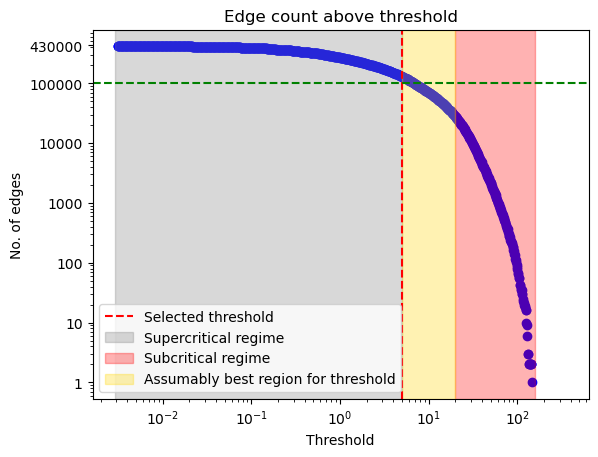

In [132]:
from matplotlib.ticker import FuncFormatter

#Just for non-exponential showcasing
def format_yticks(tick_val, pos):
    return int(tick_val)

#Plot 1: for different threshold, how many edges would we have if we only consider edges with weight above that threshold
plt.scatter(np.logspace(-2.51, 2.55, 1000), more_than_threshold, color='blue')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=5, color='red', linestyle='--', label = 'Selected threshold')
plt.axvspan(0.0029, 5, color = 'grey', alpha = 0.3, label = 'Supercritical regime' )
plt.axvspan(20, 160, color = 'red', alpha = 0.3, label = 'Subcritical regime' )
plt.axvspan(5, 20, color = 'gold', alpha = 0.3, label = 'Assumably best region for threshold' )
plt.title('Edge count above threshold')
plt.xlabel('Threshold')
plt.ylabel('No. of edges')

yticks = np.array([1, 10, 100, 1000, 10000, 100000, 430000])

plt.yticks(yticks)
plt.axhline(y=100000, xmin=0.0001, xmax=1, color='green', linestyle='--')

formatter = FuncFormatter(format_yticks)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

I selected the threshold to be somewhere near the critical point, so we still have the major component not falling apart, but fairly many edges cleared out that may show weaker links between artists. To still have most connections, I choose the value to be the lowest in the "best" region to keep most edges.

In [ ]:
threshold = 5

edges_to_remove = [] #This way, we don't change the graph while iterating over it
nodes_to_remove = []
g_copy = Graph(g)
for e in g_copy.edges():
    if weight[e] < threshold:
        edges_to_remove.append(e)
for e in edges_to_remove:
    g_copy.remove_edge(e)

#Isolated vertices deletion
for v in g_copy.vertices():
    if v.out_degree() == 0:
        nodes_to_remove.append(v)
for v in nodes_to_remove:
    try:
        g_copy.remove_vertex(v) #Not sure why we get invalid nodes here
    except:
        continue

I still had somehow 0 degree nodes (which will cause issues later), so here I decided to just select the biggest component for analysis:

In [57]:
g_biggest_component = Graph(g_copy)
g_biggest_component.set_vertex_filter(None)  # Clear any existing vertex filter
g_biggest_component.set_vertex_filter(label_largest_component(g_biggest_component))  # Keep only the largest connected component

print("Number of nodes in the subgraph: ", g_biggest_component.num_vertices()); print("Number of edges in the subgraph: ", g_biggest_component.num_edges())


Number of nodes in the subgraph:  2959
Number of edges in the subgraph:  65374


From 10000 artists with ~100000 connections, we still kept around 65000 connections between the remaining 3000 artists by selecting the largest component, average degree around 43, may be a little unrealisticly high (note again that these artists have on average 43 connections just among them, not all their connections ever)

It also has an interpretation: only those artists are kept, who on average have spent at least 5 years at places where both of them lived/worked, and then look at the biggest component.

## Degree distribution

In [ ]:
!pip install powerlaw
import powerlaw as pwl

In [60]:
#Get degrees first
degrees = g_biggest_component.get_total_degrees(g_biggest_component.get_vertices())

Calculating best minimal value for power law fit


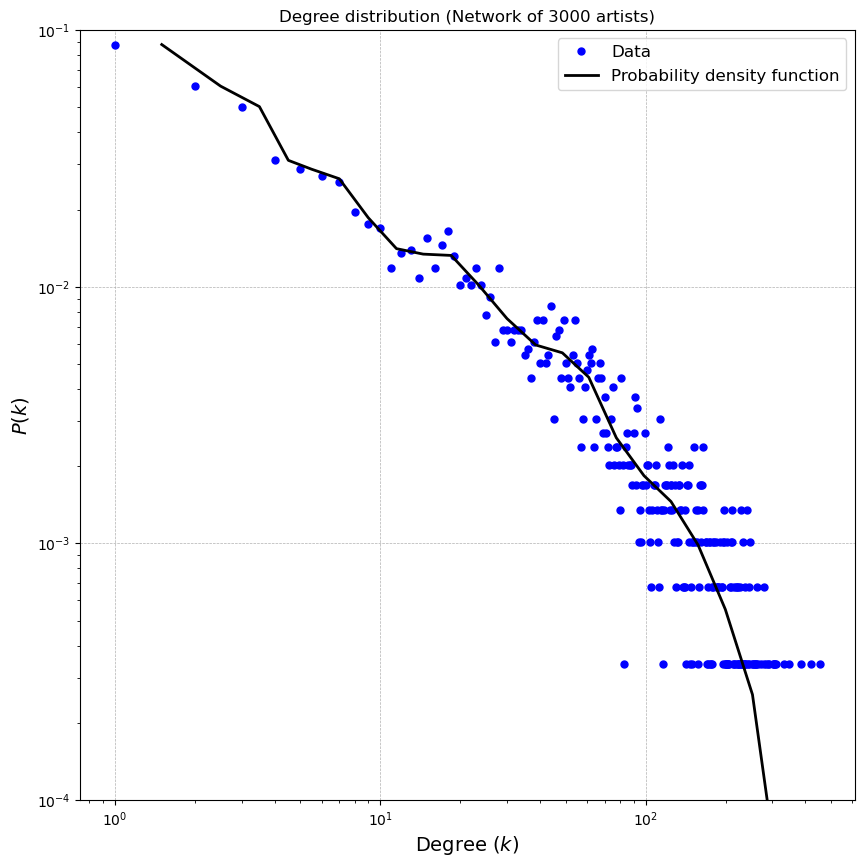

In [166]:
analysis_functions.plot_deg_dist_fit_log_single_no_fit(degrees)

In [47]:
fit_function = pwl.Fit(degrees)

print(f'Alpha: {fit_function.power_law.alpha}')
print(f'KS-distance: {fit_function.power_law.D}')

Calculating best minimal value for power law fit
Alpha: 7.623570539664112
K-S distance: 0.039369302121944894


Kolmogorov-Smirnov distance is low, which indicates a fairly good fit.

## Community detection

To find communiti

In [71]:
state = minimize_nested_blockmodel_dl(g_biggest_component, state_args=dict(recs=[g_biggest_component.ep.weight], rec_types=["real-exponential"]))

In [72]:
state.levels[0]

<BlockState object with 2959 blocks (85 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 2959 vertices and 65374 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7e8b2650d8d0, at 0x7e8b2569b110>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7e8b2650d8d0, at 0x7e8b256109d0>, False), at 0x7e8b2650d8d0>, at 0x7e8df1b96210>

We have 85 communities of the 3000 artists, which we will further analyze. Before that, it's interesting how they are connected:

**NOTE**: Output was removed to save memory, I saved it in the image subfolder as a .png

In [94]:
state.draw(edge_color=prop_to_size(g_biggest_component.ep.weight, power=1, log=True),
           eorder=g_biggest_component.ep.weight, # edge ordering is important!
           edge_pen_width=2,
          output = "image/painters_nested_blockmodel.png");



(*Note during the presentation*: -Toma: There is one small community very much interconnected, might be interesting to look at.<br>
-Tiago: Probably coloring nodes and not edges would have been more meaningful.)

## Observations from communities

We look into communities:

In [ ]:
# Create a look up table of block ids and included artist names
block_to_artist = {}
for v in g_biggest_component.vertices():
    block_id = b[v]
    artist = g_biggest_component.vertex_properties['artist_name'][v]
    if block_id not in block_to_artist:
        block_to_artist[block_id] = [] # Create the list, put the artist in it below
    block_to_artist[block_id].append(artist)

Let's see the global trends in the dataset first:

In [135]:
 analysis_functions.get_column_counts_adjusted(artists, 'Nationality')[0:3], analysis_functions.get_column_counts_adjusted(artists, 'citizenship')[0:3]

(Nationality
 American    0.149137
 French      0.094495
 British     0.081758
 Name: proportion, dtype: float64,
 citizenship
 United States of America    0.150207
 France                      0.132678
 Spain                       0.043608
 Name: proportion, dtype: float64)

In [88]:
analysis_functions.get_female_percentage(artists), analysis_functions.get_column_average(artists, 'birth_year'), analysis_functions.get_column_average(artists, 'wikiart_pictures_count')

(11.73601433406331, 1818.2762943334692, 54.729940680611925)

Now let's build a dataframe of averages, counts from blocks (functions included in the analysis_functions):

In [102]:
blocks_nationality = []; blocks_citizenship = []; blocks_gender = []; blocks_birth_year = []; blocks_wikiart_pictures_count = []; blocks_styles = []; blocks_movement = []; blocks_size = []
for block_id, artists_in_block in block_to_artist.items():
    artists_in_block_df = artists[artists['artist'].isin(artists_in_block)]
    blocks_nationality.append(analysis_functions.get_column_counts_adjusted(artists_in_block_df, 'Nationality'))
    blocks_citizenship.append(analysis_functions.get_column_counts_adjusted(artists_in_block_df, 'citizenship'))
    blocks_gender.append(analysis_functions.get_female_percentage(artists_in_block_df))
    blocks_birth_year.append(analysis_functions.get_column_average(artists_in_block_df, 'birth_year'))
    blocks_wikiart_pictures_count.append(analysis_functions.get_column_average(artists_in_block_df, 'wikiart_pictures_count'))
    blocks_styles.append(analysis_functions.get_column_counts_adjusted(artists_in_block_df, 'styles'))
    blocks_movement.append(analysis_functions.get_column_counts_adjusted(artists_in_block_df, 'movement'))
    #Add amount of artists in block to the dataframe
    blocks_size.append(len(artists_in_block))
#DF
block_data = pd.DataFrame({'Size':blocks_size, 'Nationality': blocks_nationality, 'citizenship': blocks_citizenship, 'gender': blocks_gender, 'birth_year': blocks_birth_year, 'wikiart_pictures_count': blocks_wikiart_pictures_count, 'styles': blocks_styles, 'movement': blocks_movement})


In [103]:
block_data.sort_values(by='birth_year', ascending=True)

,Size,Nationality,citizenship,gender,birth_year,wikiart_pictures_count,styles,movement
76,41,Nationality Italian 0.764706 Flemish 0.2...,citizenship Republic of Florence 0.409091...,0.000000,1413.675000,59.000000,"styles Early Renaissance, Unknown ...",movement Early Renaissance 0.736842 Nort...
81,30,Nationality German 0.666667 Dutch 0.333...,citizenship Germany 0.296...,0.000000,1505.266667,95.600000,"styles Northern Renaissance, Unknown ...",movement Northern Renaissance 1.0 Name: pro...
67,17,"Nationality Flemish 1.0 Name: proportion, d...",citizenship Habsburg Netherlands 0.3750 Net...,0.000000,1556.411765,47.500000,styles Baroque ...,"movement Baroque 1.0 Name: proportion, dtyp..."
75,70,Nationality Italian 0.814815 Fle...,citizenship Republic of Venice 0.44 Rep...,0.000000,1564.042857,106.259259,styles High Renaissance ...,movement High Renaissance 0.666667 Nort...
24,51,Nationality Italian 0.642857 Fre...,citizenship Republic of Venice 0.16...,7.843137,1573.019608,49.187500,"styles Baroque, Unknown 0.250...",movement Baroque 0.9375 Northe...
...,...,...,...,...,...,...,...,...
31,54,Nationality American 0.952381 Ame...,citizenship United States of America 0.9811...,26.415094,1931.629630,33.152174,styles Minimalism ...,movement Abstract Expressionism 0.13043...
27,61,Nationality British 0.55...,citizenship United Kingdom ...,14.754098,1934.114754,38.170213,styles Post-Minimalism ...,movement Abstract Expressionism 0.127...
45,16,Nationality American 0.857143 Leba...,citizenship United States of America 1.0 Na...,18.750000,1935.750000,26.916667,styles Minimalism ...,movement Conceptual Art 0.25000...
44,57,Nationality American 0.681818 ...,citizenship United States of America 0.7551...,17.543860,1938.035088,27.386364,styles Conceptual Art ...,movement Conceptual Art ...


We can see that the artists inside groups share nationality very much. What can we say about comparable differences between communities? Do they differ much? 

### Gender representation

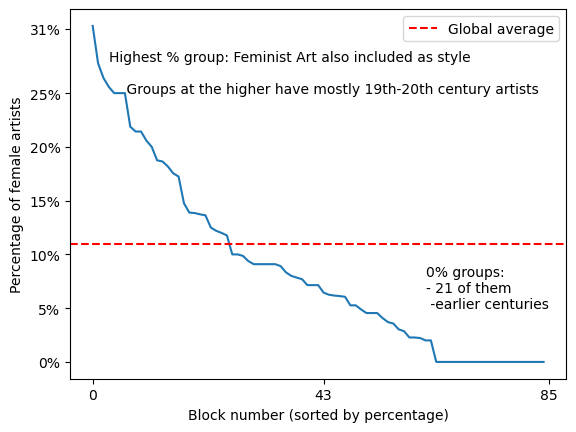

In [170]:
import matplotlib.pyplot as plt

plt.plot(block_data['gender'].sort_values(ascending=False).values)
plt.ylabel('Percentage of female artists')
plt.xlabel('Block number (sorted by percentage)')
#Add ticks, with percentages
plt.xticks([0, 43, 85])
plt.yticks([0,5,10,15,20,25,31], ["0%","5%","10%","15%","20%","25%","31%"])
plt.axhline(y=11, color='r', linestyle='--', label = 'Global average')
plt.legend()
plt.text(3, 25, 'Highest % group: Feminist Art also included as style\n\n    Groups at the higher have mostly 19th-20th century artists');
plt.text(62, 5, '0% groups:\n- 21 of them\n -earlier centuries');

Looking more into it, seems like lower percentages seem to come from earlier centuries.

Let's try to "prove" that:

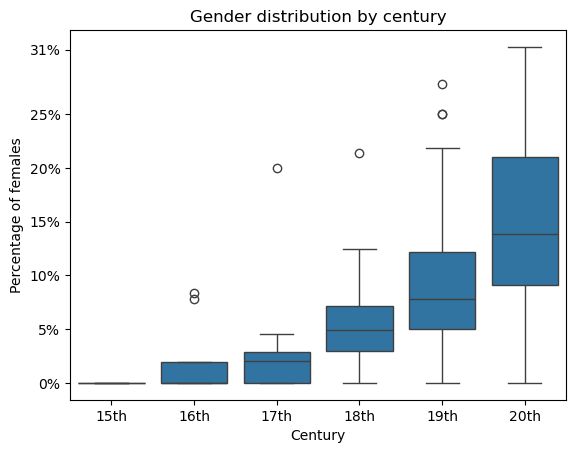

In [169]:
import seaborn as sns
import numpy as np

#Simplify to centuries
block_data['century'] = (block_data['birth_year'] // 100 + 1).astype(int)

# Create a boxplot
sns.boxplot(x='century', y='gender', data=block_data)

# Set plot labels
plt.xlabel('Century')
plt.ylabel('Percentage of females')
plt.title('Gender distribution by century')

# Set x-axis ticks
plt.xticks(np.arange(0, 6), ['15th', '16th', '17th', '18th', '19th', '20th'])
plt.yticks([0,5,10,15,20,25,31], ["0%","5%","10%","15%","20%","25%","31%"])

plt.show()

Indeed, we see this upward going trend.

### WikiArt pictures count: average per artist, plotted for all communities

This is a not bad measure of success, at least for 19th-20th century artists. (Older centuries have less paintings reserved.)

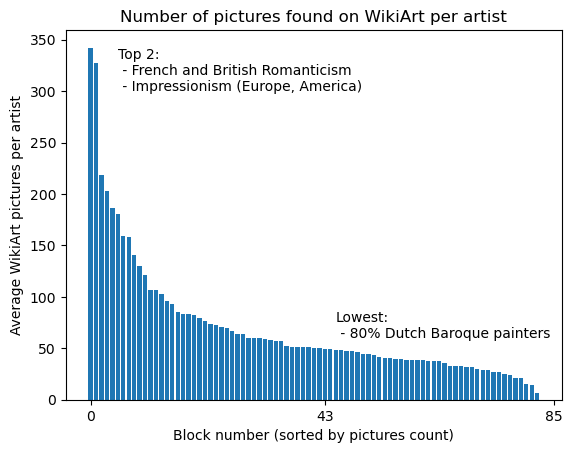

In [173]:
#Plot wikiart pictures count
plt.bar(range(len(block_data['wikiart_pictures_count'])), block_data['wikiart_pictures_count'].sort_values(ascending=False).values)
plt.ylabel('Average WikiArt pictures per artist')
plt.xlabel('Block number (sorted by pictures count)')
plt.xticks([0, 43, 85])
plt.text(5, 300, 'Top 2:\n - French and British Romanticism\n - Impressionism (Europe, America)',);
plt.text(45, 60, 'Lowest:\n - 80% Dutch Baroque painters ',);
plt.title("Number of pictures found on WikiArt per artist");
